In [32]:
import xgboost as xgb
import numpy as np
import pandas as pd
import shap

from alibi.datasets import fetch_adult

from shap import TreeExplainer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import resample

import matplotlib.pyplot as plt

from itertools import product


In [33]:
adult = fetch_adult()
adult.keys()

data = adult.data
target = adult.target
target_names = adult.target_names
feature_names = adult.feature_names
category_map = adult.category_map


np.random.seed(0)
data_perm = np.random.permutation(np.c_[data, target])
data = data_perm[:,:-1]
target = data_perm[:,-1]

idx = 30000
X_train,y_train = data[:idx,:], target[:idx]
X_test, y_test = data[idx+1:,:], target[idx+1:]

In [34]:
ordinal_features = [x for x in range(len(feature_names)) if x not in list(category_map.keys())]
ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

categorical_features = list(category_map.keys())
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])


preprocessor = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features),
                                               ('cat', categorical_transformer, categorical_features)])
preprocessor.fit(X_train)



X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("Number of training examples in {} class: {}".format(target_names[0], len(y_train) - y_train.sum()))
print("Number of training examples in {} class: {}".format(target_names[1], y_train.sum()))
print("\nNumber of testing examples in {} class: {}".format(target_names[0], len(y_test) - y_test.sum()))
print("Number of testing examples in {} class: {}".format(target_names[1], y_test.sum()))
      

numerical_feats_idx  = preprocessor.transformers_[0][2]
categorical_feats_idx  = preprocessor.transformers_[1][2]
num_feats_names = [feature_names[i] for i in numerical_feats_idx]
cat_feats_names = [feature_names[i] for i in categorical_feats_idx]
feat_names = num_feats_names + cat_feats_names
print("Feature order:")
print(feat_names)

Number of training examples in <=50K class: 22771
Number of training examples in >50K class: 7229

Number of testing examples in <=50K class: 1948
Number of testing examples in >50K class: 612
Feature order:
['Age', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']


In [35]:
def wrap(arr):
    return np.ascontiguousarray(arr)

dtrain = xgb.DMatrix(
    wrap(X_train_proc), 
    label=wrap(y_train), 
    feature_names=feat_names, 
)

dtest = xgb.DMatrix(wrap(X_test_proc), label=wrap(y_test), feature_names=feat_names)

In [36]:
import shap

In [37]:
shap.DeepExplainer

shap.explainers.deep.DeepExplainer

In [38]:
learning_params = {
    'objective':'binary:logistic',
    'seed': 42,
    'eval_metric': ['auc', 'logloss'] # metrics computed for specified dataset
}


params = { 
    'scale_pos_weight': 2,
    'min_child_weight': 0.1,
    'max_depth': 3,
    'gamma': 0.01, 
    'boost_rounds': 541,
}

params.update(learning_params)

if 'boost_rounds' in params:
    boost_rounds = params.pop('boost_rounds')

model = xgb.train(
    params,
    dtrain,
    num_boost_round=boost_rounds,
    evals=[(dtrain, "Train"), (dtest, "Test")],
)

[0]	Train-auc:0.85583	Train-logloss:0.57391	Test-auc:0.86238	Test-logloss:0.57150
[1]	Train-auc:0.86776	Train-logloss:0.50820	Test-auc:0.86981	Test-logloss:0.50651
[2]	Train-auc:0.87293	Train-logloss:0.46635	Test-auc:0.87645	Test-logloss:0.46376
[3]	Train-auc:0.88608	Train-logloss:0.43817	Test-auc:0.88777	Test-logloss:0.43724
[4]	Train-auc:0.89097	Train-logloss:0.41784	Test-auc:0.89187	Test-logloss:0.41729
[5]	Train-auc:0.89587	Train-logloss:0.39990	Test-auc:0.89655	Test-logloss:0.39890
[6]	Train-auc:0.89975	Train-logloss:0.38574	Test-auc:0.90116	Test-logloss:0.38520
[7]	Train-auc:0.90348	Train-logloss:0.37559	Test-auc:0.90578	Test-logloss:0.37432
[8]	Train-auc:0.90417	Train-logloss:0.36679	Test-auc:0.90628	Test-logloss:0.36514
[9]	Train-auc:0.90722	Train-logloss:0.35943	Test-auc:0.91048	Test-logloss:0.35752
[10]	Train-auc:0.90799	Train-logloss:0.35458	Test-auc:0.91160	Test-logloss:0.35264
[11]	Train-auc:0.90900	Train-logloss:0.34953	Test-auc:0.91212	Test-logloss:0.34784
[12]	Train-auc

[99]	Train-auc:0.93430	Train-logloss:0.28919	Test-auc:0.93330	Test-logloss:0.29822
[100]	Train-auc:0.93437	Train-logloss:0.28903	Test-auc:0.93336	Test-logloss:0.29806
[101]	Train-auc:0.93443	Train-logloss:0.28891	Test-auc:0.93339	Test-logloss:0.29801
[102]	Train-auc:0.93446	Train-logloss:0.28881	Test-auc:0.93339	Test-logloss:0.29805
[103]	Train-auc:0.93454	Train-logloss:0.28856	Test-auc:0.93342	Test-logloss:0.29804
[104]	Train-auc:0.93464	Train-logloss:0.28834	Test-auc:0.93330	Test-logloss:0.29833
[105]	Train-auc:0.93472	Train-logloss:0.28815	Test-auc:0.93339	Test-logloss:0.29821
[106]	Train-auc:0.93479	Train-logloss:0.28800	Test-auc:0.93349	Test-logloss:0.29802
[107]	Train-auc:0.93489	Train-logloss:0.28776	Test-auc:0.93354	Test-logloss:0.29786
[108]	Train-auc:0.93494	Train-logloss:0.28763	Test-auc:0.93358	Test-logloss:0.29776
[109]	Train-auc:0.93506	Train-logloss:0.28740	Test-auc:0.93342	Test-logloss:0.29795
[110]	Train-auc:0.93512	Train-logloss:0.28729	Test-auc:0.93349	Test-logloss:0

[197]	Train-auc:0.93874	Train-logloss:0.27933	Test-auc:0.93491	Test-logloss:0.29458
[198]	Train-auc:0.93878	Train-logloss:0.27923	Test-auc:0.93488	Test-logloss:0.29467
[199]	Train-auc:0.93879	Train-logloss:0.27919	Test-auc:0.93490	Test-logloss:0.29463
[200]	Train-auc:0.93884	Train-logloss:0.27907	Test-auc:0.93497	Test-logloss:0.29447
[201]	Train-auc:0.93890	Train-logloss:0.27893	Test-auc:0.93502	Test-logloss:0.29421
[202]	Train-auc:0.93900	Train-logloss:0.27876	Test-auc:0.93509	Test-logloss:0.29417
[203]	Train-auc:0.93907	Train-logloss:0.27865	Test-auc:0.93493	Test-logloss:0.29444
[204]	Train-auc:0.93911	Train-logloss:0.27856	Test-auc:0.93497	Test-logloss:0.29438
[205]	Train-auc:0.93917	Train-logloss:0.27844	Test-auc:0.93494	Test-logloss:0.29442
[206]	Train-auc:0.93924	Train-logloss:0.27835	Test-auc:0.93496	Test-logloss:0.29438
[207]	Train-auc:0.93927	Train-logloss:0.27825	Test-auc:0.93500	Test-logloss:0.29429
[208]	Train-auc:0.93928	Train-logloss:0.27823	Test-auc:0.93500	Test-logloss:

[295]	Train-auc:0.94164	Train-logloss:0.27314	Test-auc:0.93547	Test-logloss:0.29311
[296]	Train-auc:0.94168	Train-logloss:0.27307	Test-auc:0.93551	Test-logloss:0.29307
[297]	Train-auc:0.94169	Train-logloss:0.27303	Test-auc:0.93549	Test-logloss:0.29303
[298]	Train-auc:0.94175	Train-logloss:0.27291	Test-auc:0.93566	Test-logloss:0.29274
[299]	Train-auc:0.94178	Train-logloss:0.27283	Test-auc:0.93566	Test-logloss:0.29275
[300]	Train-auc:0.94181	Train-logloss:0.27277	Test-auc:0.93564	Test-logloss:0.29280
[301]	Train-auc:0.94185	Train-logloss:0.27268	Test-auc:0.93548	Test-logloss:0.29298
[302]	Train-auc:0.94191	Train-logloss:0.27259	Test-auc:0.93544	Test-logloss:0.29304
[303]	Train-auc:0.94191	Train-logloss:0.27257	Test-auc:0.93546	Test-logloss:0.29302
[304]	Train-auc:0.94193	Train-logloss:0.27252	Test-auc:0.93542	Test-logloss:0.29310
[305]	Train-auc:0.94196	Train-logloss:0.27243	Test-auc:0.93547	Test-logloss:0.29301
[306]	Train-auc:0.94200	Train-logloss:0.27236	Test-auc:0.93536	Test-logloss:

[393]	Train-auc:0.94397	Train-logloss:0.26813	Test-auc:0.93543	Test-logloss:0.29309
[394]	Train-auc:0.94399	Train-logloss:0.26809	Test-auc:0.93542	Test-logloss:0.29310
[395]	Train-auc:0.94402	Train-logloss:0.26804	Test-auc:0.93526	Test-logloss:0.29335
[396]	Train-auc:0.94406	Train-logloss:0.26796	Test-auc:0.93519	Test-logloss:0.29356
[397]	Train-auc:0.94408	Train-logloss:0.26791	Test-auc:0.93518	Test-logloss:0.29353
[398]	Train-auc:0.94408	Train-logloss:0.26790	Test-auc:0.93518	Test-logloss:0.29356
[399]	Train-auc:0.94409	Train-logloss:0.26786	Test-auc:0.93516	Test-logloss:0.29358
[400]	Train-auc:0.94411	Train-logloss:0.26781	Test-auc:0.93516	Test-logloss:0.29361
[401]	Train-auc:0.94412	Train-logloss:0.26777	Test-auc:0.93522	Test-logloss:0.29352
[402]	Train-auc:0.94415	Train-logloss:0.26773	Test-auc:0.93514	Test-logloss:0.29369
[403]	Train-auc:0.94415	Train-logloss:0.26771	Test-auc:0.93512	Test-logloss:0.29371
[404]	Train-auc:0.94418	Train-logloss:0.26766	Test-auc:0.93514	Test-logloss:

[491]	Train-auc:0.94597	Train-logloss:0.26392	Test-auc:0.93487	Test-logloss:0.29432
[492]	Train-auc:0.94599	Train-logloss:0.26388	Test-auc:0.93488	Test-logloss:0.29431
[493]	Train-auc:0.94601	Train-logloss:0.26384	Test-auc:0.93493	Test-logloss:0.29417
[494]	Train-auc:0.94601	Train-logloss:0.26383	Test-auc:0.93494	Test-logloss:0.29416
[495]	Train-auc:0.94605	Train-logloss:0.26376	Test-auc:0.93489	Test-logloss:0.29419
[496]	Train-auc:0.94607	Train-logloss:0.26371	Test-auc:0.93494	Test-logloss:0.29418
[497]	Train-auc:0.94609	Train-logloss:0.26366	Test-auc:0.93497	Test-logloss:0.29415
[498]	Train-auc:0.94612	Train-logloss:0.26361	Test-auc:0.93493	Test-logloss:0.29410
[499]	Train-auc:0.94614	Train-logloss:0.26357	Test-auc:0.93493	Test-logloss:0.29412
[500]	Train-auc:0.94615	Train-logloss:0.26356	Test-auc:0.93493	Test-logloss:0.29411
[501]	Train-auc:0.94618	Train-logloss:0.26351	Test-auc:0.93496	Test-logloss:0.29402
[502]	Train-auc:0.94618	Train-logloss:0.26348	Test-auc:0.93497	Test-logloss:

In [39]:
def plot_conf_matrix(y_test, y_pred, class_names):
    """
    Plots confusion matrix. Taken from:
    http://queirozf.com/entries/visualizing-machine-learning-models-examples-with-scikit-learn-and-matplotlib
    """
    
    matrix = confusion_matrix(y_test,y_pred)


    # place labels at the top
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')

    # plot the matrix per se
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

    # plot colorbar to the right
    plt.colorbar()

    fmt = 'd'

    # write the number of predictions in each bucket
    thresh = matrix.max() / 2.
    for i, j in product(range(matrix.shape[0]), range(matrix.shape[1])):

        # if background is dark, use a white number, and vice-versa
        plt.text(j, i, format(matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if matrix[i, j] > thresh else "black")

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label',size=14)
    plt.xlabel('Predicted label',size=14)
    plt.show()


In [40]:
y_test_pred = (model.predict(dtest) > 0.5).astype(int)

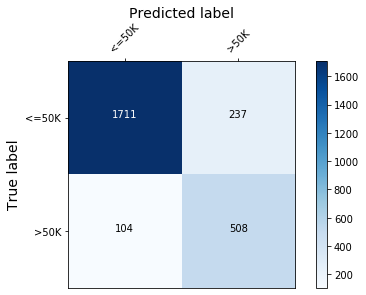

In [41]:
plot_conf_matrix(y_test, y_test_pred, target_names)

In [42]:
X_test_proc.shape

(2560, 12)

In [43]:
background_dataset = pd.DataFrame(X_train_proc[:100, :], columns=feat_names)

In [44]:
explainer = TreeExplainer(model, data=background_dataset, model_output='probability')

In [47]:
explainer.model.num_outputs

1

In [106]:
pos_idx = y_train[:100] == 1
neg_idx = y_train[:100] == 0
background_pos = pd.DataFrame(X_train_proc[:100, :][pos_idx], columns=feat_names)
background_neg = pd.DataFrame(X_train_proc[:100, :][neg_idx], columns=feat_names)
pred_pos = model.predict(xgb.DMatrix(background_pos))
pred_neg = model.predict(xgb.DMatrix(background_neg))
pred_all = model.predict(xgb.DMatrix(background_dataset))
exp_doubled = TreeExplainer(model, data=background_dataset, model_output='probability_doubled')
exp_interv = TreeExplainer(model)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [109]:
shap_inter = exp_interv.shap_interaction_values(xgb.DMatrix(X_test_proc, feature_names=feat_names))

In [112]:
shap_derived =  shap_inter.sum(axis=2)

In [113]:
shap_vals = exp_interv.shap_values(xgb.DMatrix(X_test_proc, feature_names=feat_names))

In [115]:
np.max(shap_derived - shap_vals)

1.9073486e-06

In [117]:
exp_interv.model.predict(X_test_proc).shape

(2560,)

In [96]:
print("Expected value", explainer.expected_value)
print("Average over pos class", pred_pos.mean())
print("Average over neg class", pred_neg.mean())
print("Average over all examples", np.concatenate([pred_pos, pred_neg], axis=0).mean())

Expected value 0.32489235555618945
Average over pos class 0.72594464
Average over neg class 0.18398213
Average over all examples 0.3248924


In [97]:
prob_doubled = explainer.shap_values(X_test_proc)

 99%|===================| 2524/2560 [00:19<00:00]        

In [98]:
isinstance(explainer.expected_value, float)

True

In [100]:
type(exp_doubled.expected_value)

list

In [104]:
list(background_dataset.columns)

['Age',
 'Capital Gain',
 'Capital Loss',
 'Hours per week',
 'Workclass',
 'Education',
 'Marital Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Country']

In [105]:
background_dataset.columns

Index(['Age', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Workclass',
       'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race',
       'Sex', 'Country'],
      dtype='object')

In [59]:
Z = np.array(background_dataset)

In [61]:
import catboost

In [64]:
pl = catboost.Pool(Z)

In [69]:
pl.get_features()

array([[27.,  0.,  0., ...,  4.,  0.,  9.],
       [27.,  0.,  0., ...,  4.,  0.,  9.],
       [25.,  0.,  0., ...,  4.,  1.,  9.],
       ...,
       [31.,  0.,  0., ...,  4.,  1.,  9.],
       [57.,  0.,  0., ...,  4.,  1.,  9.],
       [22.,  0.,  0., ...,  4.,  1.,  9.]], dtype=float32)

In [70]:
explainer.model.predict(pl.get_features())

array([3.42833335e-03, 5.54711488e-02, 3.12010648e-01, 5.73125580e-01,
       9.66411966e-01, 4.79909013e-01, 3.81166293e-02, 1.33474357e-01,
       5.00852259e-01, 4.64463309e-05, 1.07020216e-05, 2.91508711e-01,
       9.51830913e-01, 1.77768923e-02, 3.36934267e-01, 6.49071022e-01,
       5.57813292e-01, 6.91843255e-01, 3.67084590e-04, 1.27683275e-01,
       1.75642168e-02, 9.99707597e-01, 7.83284781e-01, 7.90709675e-03,
       9.33810726e-01, 9.44246181e-01, 5.79854131e-01, 2.97462489e-02,
       3.87990818e-05, 3.57215169e-03, 7.12693383e-02, 8.66931058e-06,
       1.05054184e-02, 1.75670255e-03, 9.99580532e-01, 1.85699431e-02,
       3.07889967e-01, 1.86477996e-01, 2.77499321e-02, 8.21063817e-01,
       4.96803090e-01, 9.47418057e-01, 9.99972889e-01, 3.10299824e-01,
       1.57287975e-01, 6.20875280e-04, 3.49599398e-01, 1.04844761e-01,
       4.84734785e-01, 1.05422918e-01, 1.31391786e-02, 9.47099432e-03,
       7.45626260e-01, 8.06507399e-03, 9.09867346e-01, 4.59497105e-02,
      

In [13]:
explainer.shap_values(pd.DataFrame(X_test_proc, columns=feat_names))

 95%|=================== | 2430/2560 [00:15<00:00]       

array([[ 0.96074681, -0.14581612, -0.13440961, ..., -0.27761659,
        -0.60182713,  0.05546092],
       [-3.39373757, -0.16872362, -0.13342329, ...,  0.06002688,
         0.36732215, -0.04778408],
       [ 0.83143794, -0.15911954, -0.12190125, ..., -0.3915471 ,
        -0.67096624,  0.04624121],
       ...,
       [-2.07073544, -0.19562366, -0.13616455, ...,  0.05749016,
        -0.32162634,  0.01712751],
       [ 1.03098262,  7.75232225, -0.08608491, ...,  0.03902876,
         0.23099037,  0.00986146],
       [-0.94469989, -4.65823403, -0.11188141, ...,  0.03069548,
         0.20961124,  0.01509398]])

In [14]:
tst = pd.DataFrame(X_test_proc, columns=feat_names)

In [ ]:
explainer

In [ ]:
explainer_path = TreeExplainer(model, model_output='probability')

In [ ]:
explainer_int = TreeExplainer(model, X_train_proc, model_output='probability')

In [ ]:
explainer_path = TreeExplainer(model)

In [ ]:
explainer_path.model.objective

In [ ]:
explainer_path.model.tree_output

In [ ]:
exp = explainer_path.shap_values(X_test_proc)

In [ ]:
exp.sum(1) - model.predict(dtest) - explainer_path.expected_value

In [ ]:
explainer_path.expected_value

In [ ]:
explainer_path_2 = TreeExplainer(model, model_output='predict')

In [ ]:
background_dataset

In [ ]:
print(np.all(model.predict(dtest) <= 1.0))
print(np.all(model.predict(dtest) >= 0.0))
print(background_dataset.shape)
print(X_test_proc.shape)

In [ ]:
explainer_interv = TreeExplainer(model, data=background_dataset, model_output='probability')

In [ ]:
explainer_interv.expected_value

In [ ]:
model.predict(xgb.DMatrix(background_dataset)).mean()

In [ ]:
sv_interv = explainer_interv.shap_values(X_test_proc)

In [ ]:
check = sv_interv.sum(1) - model.predict(dtest) + explainer_interv.expected_value

In [ ]:
np.max(check)

In [ ]:
np.min(check)

In [ ]:
np.min(model.predict(dtest))

## Check output 

In [19]:
import json

In [18]:
print(json.loads(model.save_config()))

{"learner":{"generic_param":{"enable_experimental_json_serialization":"0","gpu_id":"-1","gpu_page_size":"0","n_gpus":"0","n_jobs":"0","nthread":"0","random_state":"42","seed":"42","seed_per_iteration":"0","validate_features":"0","validate_parameters":"0"},"gradient_booster":{"gbtree_train_param":{"num_parallel_tree":"1","predictor":"auto","process_type":"default","tree_method":"exact","updater":"grow_colmaker,prune","updater_seq":"grow_colmaker,prune"},"name":"gbtree","specified_updater":false,"updater":{"grow_colmaker":{"colmaker_train_param":{"opt_dense_col":"1"},"train_param":{"alpha":"0","cache_opt":"1","colsample_bylevel":"1","colsample_bynode":"1","colsample_bytree":"1","default_direction":"learn","enable_feature_grouping":"0","eta":"0.300000012","gamma":"0.00999999978","grow_policy":"depthwise","interaction_constraints":"","lambda":"1","learning_rate":"0.300000012","max_bin":"256","max_conflict_rate":"0","max_delta_step":"0","max_depth":"3","max_leaves":"0","max_search_group":"1

In [ ]:
explainer_interv_raw = TreeExplainer(model, data=background_dataset, model_output='raw')

In [ ]:
model.predict(xgb.DMatrix(background_dataset)).mean() + 0.5

In [ ]:
explainer_interv_raw.expected_value


In [ ]:
sv_interv_raw = explainer_interv_raw.shap_values(X_test_proc)

In [ ]:
actual = sv_interv_raw.sum(1) 
expected =  model.predict(dtest) - explainer_interv_raw.expected_value
check = actual - expected

In [ ]:
check.min()

In [ ]:
explainer_interv = TreeExplainer(model, data=background_dataset, model_output='predict')

In [ ]:
model.predict


IsolationForest example

An example using :class:`sklearn.ensemble.IsolationForest` for anomaly
detection.

The IsolationForest 'isolates' observations by randomly selecting a feature
and then randomly selecting a split value between the maximum and minimum
values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the
number of splittings required to isolate a sample is equivalent to the path
length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure
of normality and our decision function.

Random partitioning produces noticeable shorter paths for anomalies.
Hence, when a forest of random trees collectively produce shorter path lengths
for particular samples, they are highly likely to be anomalies.




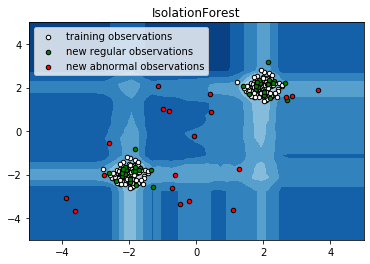

In [71]:
"""
==========================================
IsolationForest example
==========================================

An example using :class:`sklearn.ensemble.IsolationForest` for anomaly
detection.

The IsolationForest 'isolates' observations by randomly selecting a feature
and then randomly selecting a split value between the maximum and minimum
values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the
number of splittings required to isolate a sample is equivalent to the path
length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure
of normality and our decision function.

Random partitioning produces noticeable shorter paths for anomalies.
Hence, when a forest of random trees collectively produce shorter path lengths
for particular samples, they are highly likely to be anomalies.

"""
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()


In [73]:
clf.get_params()

{'behaviour': 'deprecated',
 'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 100,
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': RandomState(MT19937) at 0x7F5459511490,
 'verbose': 0,
 'warm_start': False}

In [74]:
clf.base_estimator

ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7, max_features=1,
                   max_leaf_nodes=None, min_impurity_decrease=0.0,
                   min_impurity_split=None, min_samples_leaf=1,
                   min_samples_split=2, min_weight_fraction_leaf=0.0,
                   random_state=RandomState(MT19937) at 0x7F5459511490,
                   splitter='random')

In [75]:
clf.base_estimator.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 7,
 'max_features': 1,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': RandomState(MT19937) at 0x7F5459511490,
 'splitter': 'random'}

In [77]:
clf.estimators_

[ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7, max_features=1,
                    max_leaf_nodes=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    random_state=351940553, splitter='random'),
 ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7, max_features=1,
                    max_leaf_nodes=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    random_state=572528720, splitter='random'),
 ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7, max_features=1,
                    max_leaf_nodes=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    random_state=451592010, splitter='random'),
 ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7, max_features=1,
                    max_leaf_nodes=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    random_state=1465941821, splitter='random'),
 ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7, max_features=1,
                    max_leaf_nodes=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    random_state=945938538, splitter='random'),
 ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7, max_features=1,
                    max_leaf_nodes=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    random_state=739850793, splitter='random'),
 ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7, max_features=1,
                    max_leaf_nodes=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    random_state=1003930884, splitter='random'),
 ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7, max_features=1,
                    max_leaf_nodes=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    random_state=922791370, splitter='random'),
 ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7, max_features=1,
                    max_leaf_nodes=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    random_state=828315239, splitter='random'),
 ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7, max_features=1,
                    max_leaf_nodes=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    random_state=217340943, splitter='random'),
 ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7, max_features=1,
                    max_leaf_nodes=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    random_state=688496641, splitter='random'),
 ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7, max_features=1,
                    max_leaf_nodes=None, min_impurity_decrease=0.0,
          

In [78]:
type(clf)

sklearn.ensemble._iforest.IsolationForest

In [79]:
clf.tree_

AttributeError: 'IsolationForest' object has no attribute 'tree_'

In [85]:
clf.estimators_[1].tree_.value.shape

(95, 1, 1)

In [89]:
clf.estimators_[1].tree_.node_count

95

In [90]:
clf.estimators_[1].tree_.node_count

In [91]:
explainer.expected_value

[0.6751076444438106, 0.32489235555618945]

In [1]:
import numpy as np
from typing import Sequence

In [2]:
n_feats = 60
n_records = 500
siv = np.random.random((n_records, n_feats, n_feats))

In [3]:
cat_feat_start_ind = [2, 23 , 29 , 44, 55]
cat_feat_enc_dim = [6, 3, 8, 4, 3]

In [14]:
x[:, 3, ...] - x[:, 3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [25]:
np.sum(x[..., 1:6], axis=1)

array([[4.09173963, 4.41417926, 6.02400764, 5.48809516, 5.87259496],
       [5.33389516, 4.59409602, 3.97343222, 4.04665008, 6.13346701],
       [6.41139638, 5.52782821, 3.34452716, 5.57472239, 3.93758688],
       [4.52439509, 6.05244749, 6.29082862, 5.11518657, 5.87012858],
       [5.9387843 , 4.97311894, 4.937284  , 4.97589633, 4.12215946],
       [6.64157314, 3.76173863, 4.8123201 , 3.88942553, 5.93111351],
       [4.85518323, 2.94798228, 5.32590265, 6.24051448, 4.82468084],
       [5.49531852, 5.7940391 , 5.42390052, 5.227326  , 4.97825793],
       [5.59836022, 5.06734663, 5.05568536, 4.71265931, 3.99133226],
       [6.27169768, 4.35544355, 5.7084528 , 4.53285266, 4.39290002],
       [6.27327607, 4.72100568, 5.36698286, 5.22286541, 5.86791326],
       [5.9128265 , 3.06018466, 4.88872742, 5.49337671, 4.55234769],
       [4.65549257, 5.58180966, 5.86428456, 4.36565156, 5.28386661],
       [7.56555368, 4.64849226, 5.53051857, 3.9218158 , 4.35608228],
       [4.9843633 , 5.28572411, 5.

In [17]:
x.shape[0]

50

In [28]:
x[1][...,1:3]

array([[0.64881579, 0.66122656],
       [0.62726873, 0.59496189],
       [0.31036755, 0.47910748],
       [0.94445598, 0.59319475],
       [0.92876202, 0.05809379],
       [0.51305421, 0.51450576],
       [0.13870281, 0.50998617],
       [0.46798715, 0.5373956 ],
       [0.49432769, 0.14680765],
       [0.26015322, 0.49881636]])

In [41]:
(x[..., 1:3]).sum(1).shape

(50, 2)

In [38]:
x[..., 1:3].shape

(50, 10, 2)

In [46]:
(x[..., 1:3]).sum(2).shape

(50, 10)

In [48]:
I = np.array([0, 0, 1, 0, 2, 1])

I == 0

array([ True,  True, False,  True, False, False])

In [49]:
I = np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2])

In [50]:
np.argsort(I)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [69]:
X = np.random.random((70, 50))

In [70]:
X.shape

(70, 50)

In [81]:
red_X = np.add.reduceat(X, [0, 3, 6, 12])

In [82]:
red_X_2  = np.add.reduceat(X, [0, 3], 1)

In [83]:
red_X_2.shape

(70, 2)

In [84]:
red_X_2[:, 0] - np.sum(X[:, 0:3], 1)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.44089210e-16,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -4.44089210e-16,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.22044605e-16,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [97]:
x = np.linspace(0, 15, 16).reshape(4,4)
y = np.concatenate([x, x, x], axis=1)


In [101]:
y

array([[ 0.,  1.,  2.,  3.,  0.,  1.,  2.,  3.,  0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.,  4.,  5.,  6.,  7.,  4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.,  8.,  9., 10., 11.,  8.,  9., 10., 11.],
       [12., 13., 14., 15., 12., 13., 14., 15., 12., 13., 14., 15.]])

In [139]:
np.add.reduceat(y, indices=[0, 3, 4, 5, 6, 9, 10, 11], axis=1)

array([[ 3.,  3.,  0.,  1.,  5.,  1.,  2.,  3.],
       [15.,  7.,  4.,  5., 17.,  5.,  6.,  7.],
       [27., 11.,  8.,  9., 29.,  9., 10., 11.],
       [39., 15., 12., 13., 41., 13., 14., 15.]])

In [104]:
z = np.stack([y]*3)


In [105]:
z

array([[[ 0.,  1.,  2.,  3.,  0.,  1.,  2.,  3.,  0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.,  4.,  5.,  6.,  7.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.,  8.,  9., 10., 11.,  8.,  9., 10., 11.],
        [12., 13., 14., 15., 12., 13., 14., 15., 12., 13., 14., 15.]],

       [[ 0.,  1.,  2.,  3.,  0.,  1.,  2.,  3.,  0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.,  4.,  5.,  6.,  7.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.,  8.,  9., 10., 11.,  8.,  9., 10., 11.],
        [12., 13., 14., 15., 12., 13., 14., 15., 12., 13., 14., 15.]],

       [[ 0.,  1.,  2.,  3.,  0.,  1.,  2.,  3.,  0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.,  4.,  5.,  6.,  7.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.,  8.,  9., 10., 11.,  8.,  9., 10., 11.],
        [12., 13., 14., 15., 12., 13., 14., 15., 12., 13., 14., 15.]]])

In [114]:
t = np.add.reduceat(z, [0, 3, 4, 5, 6, 9, 10, 11], 2)

In [122]:
k = np.concatenate([y]*3, axis=0)

In [124]:
l = np.stack([k]*10)

In [145]:
from functools import partial
idx  = [0, 3, 4, 5, 6, 9, 10, 11]

func = lambda arr, axis, indices=idx: np.add.reduceat(arr, indices, axis)
# func = partial(np.add.reduceat, indices=idx)

In [146]:
m = np.apply_over_axes(func, l, axes=[2, 1])

In [152]:
z.shape

(3, 4, 12)

In [153]:
t.shape

(3, 4, 8)

In [150]:
l.shape

(10, 12, 12)

In [149]:
m.shape

(10, 8, 8)

In [136]:
func(l, axis=2).shape

(10, 12, 8)

In [128]:
l

array([[[ 0.,  1.,  2., ...,  1.,  2.,  3.],
        [ 4.,  5.,  6., ...,  5.,  6.,  7.],
        [ 8.,  9., 10., ...,  9., 10., 11.],
        ...,
        [ 4.,  5.,  6., ...,  5.,  6.,  7.],
        [ 8.,  9., 10., ...,  9., 10., 11.],
        [12., 13., 14., ..., 13., 14., 15.]],

       [[ 0.,  1.,  2., ...,  1.,  2.,  3.],
        [ 4.,  5.,  6., ...,  5.,  6.,  7.],
        [ 8.,  9., 10., ...,  9., 10., 11.],
        ...,
        [ 4.,  5.,  6., ...,  5.,  6.,  7.],
        [ 8.,  9., 10., ...,  9., 10., 11.],
        [12., 13., 14., ..., 13., 14., 15.]],

       [[ 0.,  1.,  2., ...,  1.,  2.,  3.],
        [ 4.,  5.,  6., ...,  5.,  6.,  7.],
        [ 8.,  9., 10., ...,  9., 10., 11.],
        ...,
        [ 4.,  5.,  6., ...,  5.,  6.,  7.],
        [ 8.,  9., 10., ...,  9., 10., 11.],
        [12., 13., 14., ..., 13., 14., 15.]],

       ...,

       [[ 0.,  1.,  2., ...,  1.,  2.,  3.],
        [ 4.,  5.,  6., ...,  5.,  6.,  7.],
        [ 8.,  9., 10., ...,  9., 10., 11.

In [154]:
mmm = []

In [155]:
mmm.extend([3, 4])

In [156]:
mmm

[3, 4]

In [157]:
mmm.extend((6,7,8))

In [158]:
mmm

[3, 4, 6, 7, 8]

In [160]:
x.shape

(4, 4)

In [161]:
x

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.]])

In [168]:
np.add.reduceat(x, [0, 1, 2], axis=1)

array([[ 0.,  1.,  5.],
       [ 4.,  5., 13.],
       [ 8.,  9., 21.],
       [12., 13., 29.]])

In [2]:
import numpy as np
from typing import List, Sequence, Union, Tuple
from functools import partial

In [9]:
def _slice_array(start, dim, arr_trailing_dim):
    
    idx = []
    if start[0] > 0:
        idx.extend(tuple(range(start[0])))
    idx.extend([start[0], start[0] + dim [0]])
    for s_idx, d in zip(start[1:], dim[1:]):
        last_idx = idx[-1]
        while last_idx < s_idx - 1:
            last_idx += 1
            idx.append(last_idx)
        if s_idx == last_idx:
            idx.append(s_idx +d)
        else:
            idx.extend((s_idx, s_idx + d))
        
        
    if start[-1] + dim[-1] == arr_trailing_dim:
        idx.pop()
        return idx
    
    last_idx = idx[-1]
    if last_idx < arr_trailing_dim:
        while last_idx < arr_trailing_dim - 1:
            last_idx += 1
            idx.append(last_idx)
        
    return idx

def _get_slices_simple(start: Tuple, dim: Tuple, arr_trailing_dim: int) -> List[int]:
    """
    Given start indices, encoding dimensions and the array trailing shape, this function returns
    an array where contiguous numbers are slices. This array is used to reduce along an axis
    only the slices `slice(start[i], start[i]+dim[i], 1)` from a tensor and leave all other slices
    unchanged.
    """

    idx = []  # type: List[int]
    pos = 0 
    # first columns may not be reduced
    if start[0] > 0:
        idx.extend(tuple(range(start[0])))

    # add all slices to reduce
    idx.extend([start[0], start[0] + dim[0]])
    pos = len(idx)
    for s_idx, d in zip(start[1:], dim[1:]):
        last_idx = idx[-1]
        # some columns might not be reduced
        idx.extend(tuple(range(pos, s_idx)))
        if s_idx == last_idx:
            idx.append(s_idx + d)
        else:
            idx.extend((s_idx, s_idx + d))
        pos += (s_idx - pos + d)

    if pos < arr_trailing_dim:
        idx.extend(tuple(range(pos, arr_trailing_dim)))

    # avoid index error
    if start[-1] + dim[-1] == arr_trailing_dim:
        idx.pop()
        return idx

    return idx



In [23]:
def sum_categories(values: np.ndarray, 
                   start_idx: Union[List[int], Tuple[int]], 
                   enc_feat_dim: Union[List[int], Tuple[int]]):
    """
    For each entry in start_idx, the function sums the following k columns where k is the
    corresponding entry in the enc_feat_dim sequence. The columns whose indices are not in
    start_idx are left unchanged.

    Parameters
    ----------
    values
        The array whose columns will be summed.
    start_idx
        The start indices of the columns to be summed.
    enc_feat_dim
        The number of columns to be summed, one for each start index.

    Returns
    -------
    new_values
        An array whose columns have been summed according to the entries in start_idx and enc_feat_dim.
    """
    
    if start_idx is None or enc_feat_dim is None:
        raise ValueError("Both the start indices or the encoding dimension need to be specified!")

    if not len(enc_feat_dim) == len(start_idx):
        raise ValueError("The lengths of the sequences of start indices and encodings must be equal!")

    n_encoded_levels = sum(enc_feat_dim)
    if n_encoded_levels > values.shape[-1]:
        raise ValueError("The sum of the encoded features dimensions exceeds data dimension!")
        
    
    def _get_slices(start: List[int], dim: List[int], arr_trailing_dim: int):
        """
        Given start indices, encoding dimensions and the array trailing shape,
        this function returns an array where contiguous numbers are slices, 
        This array is used to reduce along an axis only the slices 
        `slice(start[i], start[i]+dim[i], None)` from a tensor and leave all o
        ther slices unchanged. 
        """
        
        idx = []
        # first columns do not change
        if start[0] > 0:
            idx.extend(tuple(range(start[0])))
        
        # add all slices
        idx.extend([start[0], start[0] + dim [0]])
        for s_idx, d in zip(start[1:], dim[1:]):
            last_idx = idx[-1]
            # some columns might remain the same
            while last_idx < s_idx - 1:
                last_idx += 1
                idx.append(last_idx)
            if s_idx == last_idx:
                idx.append(s_idx +d)
            else:
                idx.extend((s_idx, s_idx + d))

        # avoid index error
        if start[-1] + dim[-1] == arr_trailing_dim:
            idx.pop()
            return idx
        
        # last few columns might remain the same 
        last_idx = idx[-1]
        if last_idx < arr_trailing_dim:
            while last_idx < arr_trailing_dim - 1:
                last_idx += 1
                idx.append(last_idx)
        
        return idx
    
    def _reduction(arr, axis, indices=None):
        return np.add.reduceat(arr, indices, axis)
    
    
    # create array of slices to be reduced
    slices = _get_slices(start_idx, enc_feat_dim, values.shape[-1])
    if len(values.shape) == 3:
        reduction = partial(_reduction, indices=slices)
        return np.apply_over_axes(reduction, values, axes=(2, 1))
    return np.add.reduceat(values, slices , axis=1)



def sum_categories_new(values: np.ndarray, 
                       start_idx: Union[List[int], Tuple[int]], 
                       enc_feat_dim: Union[List[int], Tuple[int]]):
    """
    For each entry in start_idx, the function sums the following k columns where k is the
    corresponding entry in the enc_feat_dim sequence. The columns whose indices are not in
    start_idx are left unchanged.

    Parameters
    ----------
    values
        The array whose columns will be summed.
    start_idx
        The start indices of the columns to be summed.
    enc_feat_dim
        The number of columns to be summed, one for each start index.

    Returns
    -------
    new_values
        An array whose columns have been summed according to the entries in start_idx and enc_feat_dim.
    """
    
    if start_idx is None or enc_feat_dim is None:
        raise ValueError("Both the start indices or the encoding dimension need to be specified!")

    if not len(enc_feat_dim) == len(start_idx):
        raise ValueError("The lengths of the sequences of start indices and encodings must be equal!")

    n_encoded_levels = sum(enc_feat_dim)
    if n_encoded_levels > values.shape[-1]:
        raise ValueError("The sum of the encoded features dimensions exceeds data dimension!")
        
    
    def _get_slice_simple(start: Tuple, dim: Tuple, arr_trailing_dim: int) -> List[int]:
        """
        Given start indices, encoding dimensions and the array trailing shape, this function returns
        an array where contiguous numbers are slices. This array is used to reduce along an axis
        only the slices `slice(start[i], start[i]+dim[i], 1)` from a tensor and leave all other slices
        unchanged.
        """

        slices = []  # type: List[int]
        idx = 0

        for s, nelem in zip(start, dim):
            slices.extend(tuple(range(idx, s)))
            if slices[-1]  == s:
                slices.append(s + nelem)
            else:
                slices.extend((s, s + nelem))
            idx += (s - idx + nelem)
        if idx < arr_trailing_dim:
            slices.extend(tuple(range(idx, arr_trailing_dim)))

        # avoid index error
        if start[-1] + dim[-1] == arr_trailing_dim:
            slices.pop()

        return slices

    def _reduction(arr, axis, indices=None):
        return np.add.reduceat(arr, indices, axis)
    
    
    # create array of slices to be reduced
    slices = _get_slice_simple(start_idx, enc_feat_dim, values.shape[-1])
    if len(values.shape) == 3:
        reduction = partial(_reduction, indices=slices)
        return np.apply_over_axes(reduction, values, axes=(2, 1))
    return np.add.reduceat(values, slices , axis=1)


    
def sum_categories_2D(values: np.ndarray, 
                      start_idx: Union[List[int], Tuple[int]], 
                      enc_feat_dim: Union[List[int], Tuple[int]]):
    """
    For each entry in start_idx, the function sums the following k columns where k is the
    corresponding entry in the enc_feat_dim sequence. The columns whose indices are not in
    start_idx are left unchanged.

    Parameters
    ----------
    values
        The array whose columns will be summed.
    start_idx
        The start indices of the columns to be summed.
    enc_feat_dim
        The number of columns to be summed, one for each start index.

    Returns
    -------
    new_values
        An array whose columns have been summed according to the entries in start_idx and enc_feat_dim.
    """

    if start_idx is None or enc_feat_dim is None:
        raise ValueError("Both the start indices or the encoding dimension need to be specified!")

    if not len(enc_feat_dim) == len(start_idx):
        raise ValueError("The lengths of the sequences of start indices and encodings must be equal!")

    n_encoded_levels = sum(enc_feat_dim)
    if n_encoded_levels > values.shape[1]:
        raise ValueError("The sum of the encoded features dimensions exceeds data dimension!")

    new_values = np.zeros((values.shape[0], values.shape[1] - n_encoded_levels + len(enc_feat_dim)))

    # find all the other indices of categorical columns other than those specified
    cat_cols = []
    for start, feat_dim in zip(start_idx, enc_feat_dim):
        for i in range(1, feat_dim):
            cat_cols.append(start + i)

    # sum the columns corresponding to a categorical variable
    enc_idx, new_vals_idx = 0, 0
    for idx in range(values.shape[1]):
        if idx in start_idx:
            feat_dim = enc_feat_dim[enc_idx]
            enc_idx += 1
            stop_idx = idx + feat_dim
            new_values[:, new_vals_idx] = np.sum(values[:, idx:stop_idx], axis=1)
        elif idx in cat_cols:
            continue
        else:
            new_values[:, new_vals_idx] = values[:, idx]
        new_vals_idx += 1

    return new_values


    
def sum_categories_2D(values: np.ndarray, 
                      start_idx: Union[List[int], Tuple[int]], 
                      enc_feat_dim: Union[List[int], Tuple[int]]):
    """
    For each entry in start_idx, the function sums the following k columns where k is the
    corresponding entry in the enc_feat_dim sequence. The columns whose indices are not in
    start_idx are left unchanged.

    Parameters
    ----------
    values
        The array whose columns will be summed.
    start_idx
        The start indices of the columns to be summed.
    enc_feat_dim
        The number of columns to be summed, one for each start index.

    Returns
    -------
    new_values
        An array whose columns have been summed according to the entries in start_idx and enc_feat_dim.
    """

    if start_idx is None or enc_feat_dim is None:
        raise ValueError("Both the start indices or the encoding dimension need to be specified!")

    if not len(enc_feat_dim) == len(start_idx):
        raise ValueError("The lengths of the sequences of start indices and encodings must be equal!")

    n_encoded_levels = sum(enc_feat_dim)
    if n_encoded_levels > values.shape[1]:
        raise ValueError("The sum of the encoded features dimensions exceeds data dimension!")

    new_values = np.zeros((values.shape[0], values.shape[1] - n_encoded_levels + len(enc_feat_dim)))

    # find all the other indices of categorical columns other than those specified
    cat_cols = []
    for start, feat_dim in zip(start_idx, enc_feat_dim):
        for i in range(1, feat_dim):
            cat_cols.append(start + i)

    # sum the columns corresponding to a categorical variable
    enc_idx, new_vals_idx = 0, 0
    for idx in range(values.shape[1]):
        if idx in start_idx:
            feat_dim = enc_feat_dim[enc_idx]
            enc_idx += 1
            stop_idx = idx + feat_dim
            new_values[:, new_vals_idx] = np.sum(values[:, idx:stop_idx], axis=1)
        elif idx in cat_cols:
            continue
        else:
            new_values[:, new_vals_idx] = values[:, idx]
        new_vals_idx += 1

    return new_values


    

In [17]:
X = np.ones((10, 50), dtype=int)
start = [3, 11, 20, 30]
dim = [5, 2, 4, 7]
old = sum_categories_2D(X, start, dim)
v1 = sum_categories(X, start, dim)
new = sum_categories_new(X, start, dim)

In [18]:
v1.shape

(10, 36)

In [19]:
old.shape == new.shape == v1.shape

False

In [43]:
old - new

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.,

In [44]:
x = np.ones((5, 20, 20))

In [45]:
start = [0, 6, 14]
dim = [3, 4, 6]

In [46]:
test = sum_categories_new(x, start, dim)

In [49]:
test

array([[[ 9.,  3.,  3.,  3., 12.,  3.,  3.,  3.,  3., 18.],
        [ 3.,  1.,  1.,  1.,  4.,  1.,  1.,  1.,  1.,  6.],
        [ 3.,  1.,  1.,  1.,  4.,  1.,  1.,  1.,  1.,  6.],
        [ 3.,  1.,  1.,  1.,  4.,  1.,  1.,  1.,  1.,  6.],
        [12.,  4.,  4.,  4., 16.,  4.,  4.,  4.,  4., 24.],
        [ 3.,  1.,  1.,  1.,  4.,  1.,  1.,  1.,  1.,  6.],
        [ 3.,  1.,  1.,  1.,  4.,  1.,  1.,  1.,  1.,  6.],
        [ 3.,  1.,  1.,  1.,  4.,  1.,  1.,  1.,  1.,  6.],
        [ 3.,  1.,  1.,  1.,  4.,  1.,  1.,  1.,  1.,  6.],
        [18.,  6.,  6.,  6., 24.,  6.,  6.,  6.,  6., 36.]],

       [[ 9.,  3.,  3.,  3., 12.,  3.,  3.,  3.,  3., 18.],
        [ 3.,  1.,  1.,  1.,  4.,  1.,  1.,  1.,  1.,  6.],
        [ 3.,  1.,  1.,  1.,  4.,  1.,  1.,  1.,  1.,  6.],
        [ 3.,  1.,  1.,  1.,  4.,  1.,  1.,  1.,  1.,  6.],
        [12.,  4.,  4.,  4., 16.,  4.,  4.,  4.,  4., 24.],
        [ 3.,  1.,  1.,  1.,  4.,  1.,  1.,  1.,  1.,  6.],
        [ 3.,  1.,  1.,  1.,  4.,  1.,

In [47]:
test.shape

(5, 10, 10)

In [14]:
list(range(2, 2))

[]

In [10]:
start = [0, 2]
dim = [2, 3]
arr_trailing_dim = 8

In [11]:
test_idx = _slice_array(start, dim , arr_trailing_dim)
print(test_idx)
print(_get_slices_simple(start, dim, arr_trailing_dim))

[0, 2, 5, 6, 7]
[0, 2, 5, 5, 6, 7]


In [30]:
np.add.reduceat(X, test_idx, 1)

array([[ 1,  9,  5,  6,  7],
       [17, 33, 13, 14, 15]])

In [31]:
start = [5]
dim = [3]
arr_trailing_dim = 8

In [32]:
test_idx = _slice_array(start, dim , arr_trailing_dim)
print(test_idx)

[0, 1, 2, 3, 4, 5]


In [33]:
X

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15]])

In [34]:
np.add.reduceat(X, test_idx, 1)

array([[ 0,  1,  2,  3,  4, 18],
       [ 8,  9, 10, 11, 12, 42]])

In [35]:
start = [0, 5]
dim = [2, 3]

In [36]:
X

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15]])

In [37]:
test_idx = _slice_array(start, dim, arr_trailing_dim)
print(test_idx)

[0, 2, 3, 4, 5]


In [38]:
np.add.reduceat(X, test_idx , 1)

array([[ 1,  2,  3,  4, 18],
       [17, 10, 11, 12, 42]])

In [39]:
start = [3, 5]
dim = [2, 3]

In [40]:
X

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15]])

In [41]:
np.add.reduceat(X, _slice_array(start, dim, arr_trailing_dim), 1)

array([[ 0,  1,  2,  7, 18],
       [ 8,  9, 10, 23, 42]])

In [42]:
start = [3]
dim = [2]

In [43]:
X

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15]])

In [44]:
np.add.reduceat(X, _slice_array(start, dim, arr_trailing_dim), 1)

array([[ 0,  1,  2,  7,  5,  6,  7],
       [ 8,  9, 10, 23, 13, 14, 15]])

In [50]:
X = np.arange(40).reshape(10, 2, 2)

In [51]:
X

array([[[ 0,  1],
        [ 2,  3]],

       [[ 4,  5],
        [ 6,  7]],

       [[ 8,  9],
        [10, 11]],

       [[12, 13],
        [14, 15]],

       [[16, 17],
        [18, 19]],

       [[20, 21],
        [22, 23]],

       [[24, 25],
        [26, 27]],

       [[28, 29],
        [30, 31]],

       [[32, 33],
        [34, 35]],

       [[36, 37],
        [38, 39]]])

In [54]:
X[..., 1].shape

(10, 2)

In [55]:
x = np.array(np.arange(10))

In [56]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [63]:
y =  np.concatenate((x[:4], np.array([np.sum(x[4:7])]), x[7:]))

In [64]:
x[7:]

array([7, 8, 9])

In [65]:
y

array([ 0,  1,  2,  3, 15,  7,  8,  9])

In [66]:
x = [np.array([2, 3, 4]), np.array([3, 4, 6])]

In [67]:
np.stack(x)

array([[2, 3, 4],
       [3, 4, 6]])

In [70]:
start_idx = [0, 6, 12, 21]
feat_enc_dim = [3, 2, 4, 6]

In [72]:
slice_indices = []
for slice_s, nelem in zip(start_idx, feat_enc_dim):
    slice_indices.extend(tuple(range(slice_s, slice_s + nelem)))
                    

In [73]:
slice_indices

[0, 1, 2, 6, 7, 12, 13, 14, 15, 21, 22, 23, 24, 25, 26]

In [74]:
slice(0, 2, 1)

slice(0, 2, 1)

In [75]:
x = slice(0, 2, 1)

In [76]:
1 in x

TypeError: argument of type 'slice' is not iterable

In [77]:
slice(range(5))

slice(None, range(0, 5), None)

In [78]:
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [79]:
x[slice(range(5))]

TypeError: slice indices must be integers or None or have an __index__ method

In [80]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [81]:
x[range(5)]

array([0, 1, 2, 3, 4])

In [82]:
x[range(2,5)]

array([2, 3, 4])

In [83]:
range(2, 5)

range(2, 5)

In [84]:
len(range(2, 5))

3

In [85]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [86]:
x.shape

(9,)

In [87]:
x[30:]

array([], dtype=int64)

In [88]:
list(x[30:])

[]

In [91]:
x[slice(1, 5, 1)]

array([1, 2, 3, 4])

In [92]:
range.start

<member 'start' of 'range' objects>

In [97]:
r = range(2,8)

In [98]:
r.start

2

In [99]:
r.stop

8

In [100]:
a = (2, 3, 4)

In [101]:
a[1:]

(3, 4)

In [103]:
def fun(a, b, **kwargs):
    print(kwargs)

In [104]:
fun(1, 2, c=1, d=2)

{'c': 1, 'd': 2}


In [105]:
tr = range(6, 12)

In [107]:
n = []
c = 0
n.extend(tuple(range(c, tr.start)))

In [108]:
n

[0, 1, 2, 3, 4, 5]

In [109]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [110]:
list(x)

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [7]:
import numpy as np
import pandas as pd

In [8]:
x = np.array([])

In [9]:
x.size == 0

True

In [10]:
x = np.random.random((50, 10))

In [11]:
x.shape

(50, 10)

In [24]:
df = pd.DataFrame(data=x)

In [25]:
x.ndim

2

In [26]:
import shap

In [31]:
shap.kmeans(df, 10).data

array([[0.65157691, 0.7281689 , 0.71478345, 0.44497366, 0.64486658,
        0.28245375, 0.7156696 , 0.81022938, 0.59674478, 0.58049425],
       [0.68421615, 0.65308577, 0.40047649, 0.80726417, 0.41652105,
        0.65704939, 0.27242645, 0.64336904, 0.259407  , 0.58049425],
       [0.8957094 , 0.18047929, 0.64023675, 0.76975906, 0.41652105,
        0.28245375, 0.32018815, 0.71332807, 0.57497935, 0.58049425],
       [0.30386129, 0.39556042, 0.23240583, 0.54580547, 0.349761  ,
        0.90799866, 0.52802372, 0.48182703, 0.75461195, 0.36415503],
       [0.41254363, 0.42647575, 0.79758428, 0.54580547, 0.69980883,
        0.22198415, 0.52802372, 0.17258613, 0.30850524, 0.31199116],
       [0.6018119 , 0.45167187, 0.85461957, 0.60640252, 0.25789881,
        0.45806269, 0.59451907, 0.26587505, 0.80719604, 0.73021112],
       [0.36159671, 0.70827906, 0.79758428, 0.27671825, 0.09988919,
        0.77959622, 0.30514836, 0.43838391, 0.38803452, 0.90009175],
       [0.35256088, 0.54002813, 0.0840116

In [28]:
shap.sample(df, 10)

,0,1,2,3,4,5,6,7,8,9
44,0.481583,0.708279,0.202035,0.649735,0.790464,0.242740,0.154138,0.867905,0.859231,0.936896
47,0.503710,0.831491,0.835078,0.237303,0.026516,0.884624,0.147237,0.491339,0.453251,0.996594
0,0.235457,0.718770,0.741104,0.395503,0.577890,0.118477,0.272426,0.053748,0.163020,0.868963
3,0.385220,0.914692,0.380352,0.357846,0.051988,0.891329,0.668393,0.607131,0.614707,0.364155
3,0.385220,0.914692,0.380352,0.357846,0.051988,0.891329,0.668393,0.607131,0.614707,0.364155
39,0.037030,0.051106,0.990858,0.191194,0.815265,0.036264,0.497874,0.302452,0.035630,0.142579
9,0.578762,0.426476,0.018618,0.545805,0.775796,0.907999,0.812721,0.014046,0.345731,0.108275
19,0.596977,0.540028,0.822734,0.769759,0.442290,0.155670,0.594519,0.917090,0.673412,0.477911
21,0.776329,0.046687,0.730683,0.107414,0.784005,0.861631,0.254586,0.085024,0.807196,0.694702
36,0.379829,0.117711,0.102567,0.286975,0.887828,0.220739,0.528024,0.265875,0.599415,0.377041


In [23]:
type(x)

numpy.ndarray